# Multispectral Rendering

This notebook demonstrates how to solve the Radiative Transfer using SHDOM and render multispectral images. 

The images rendered are at several wavelengths for which a mie tables were previously calculated.

---

Related tutorials: 
 - Make Mie Table.ipynb - how to create mie tables
 - Single Image Rendering.ipynb - how to create a single monochromatic image
 - Multiview Rendering.ipynb - how to create multiview images

---

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import shdom

In [2]:
""" 
Load mie tables at several wavelengths and generate an RteSolverArray.
Spectral solar fluxes at each wavelength are calculated based on extraterrestrial solar spectrum at 1AU

Note:
These mie tables need to be calculated prior to running this cell
"""
wavelengths = [0.672, 0.550, 0.445]
mie_table_paths = ['../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(wavelength)) \
                   for wavelength in wavelengths]
                                                                       
solar_spectrum = shdom.SolarSpectrum('../ancillary_data/SpectralSolar_MODWehrli_1985_WMO.npz')
solar_fluxes = solar_spectrum.get_monochrome_solar_flux(wavelengths)
solar_fluxes = solar_fluxes / max(solar_fluxes)


temperatures = np.array([292.220, 292.040, 291.860, 291.680, 291.500, 291.320, 291.140, 290.960, 290.780, 
                         290.600, 290.420, 290.240, 290.060, 289.880, 289.700, 289.920, 290.140, 290.360, 
                         290.580, 290.800, 291.020, 291.240, 291.460, 291.680, 291.900])
air_molecules_grid = shdom.Grid(z=np.linspace(0.0, 20.0, len(temperatures)))
temperature_profile = shdom.GridData(air_molecules_grid, temperatures)

# Generate multi-spectral scatterers for both droplets and air molecules
droplets = shdom.MicrophysicalScatterer()
droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/rico32x36x25.txt', veff=0.1)
air = shdom.MultispectralScatterer()

for wavelength, table_path in zip(wavelengths, mie_table_paths):
    
    # Molecular Rayleigh scattering
    rayleigh = shdom.Rayleigh(wavelength)
    rayleigh.set_profile(temperature_profile)
    air.add_scatterer(rayleigh.get_scatterer())
    
    # Droplet Mie scattering
    mie = shdom.MiePolydisperse()
    mie.read_table(table_path)
    droplets.add_mie(mie)
    
# Generate an atmospheric medium with both scatterers
atmospheric_grid = droplets.grid + air.grid
atmosphere = shdom.Medium(atmospheric_grid)
atmosphere.add_scatterer(droplets, name='cloud')
atmosphere.add_scatterer(air, name='air')

# Generate a solver array for a multispectral solution
rte_solvers = shdom.RteSolverArray()

for wavelength, solar_flux in zip(wavelengths, solar_fluxes):
    numerical_params = shdom.NumericalParameters()
    scene_params = shdom.SceneParameters(
        wavelength=wavelength,
        source=shdom.SolarSource(azimuth=0, zenith=180, flux=solar_flux)
    ) 
    rte_solver = shdom.RteSolver(scene_params, numerical_params)
    rte_solver.set_medium(atmosphere)
    rte_solvers.add_solver(rte_solver)

Reading mie table from file: ../mie_tables/polydisperse/Water_672nm.scat
Reading mie table from file: ../mie_tables/polydisperse/Water_550nm.scat
Reading mie table from file: ../mie_tables/polydisperse/Water_445nm.scat


In [3]:
"""
Solve the Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (shdomsub1.f).
The outputs are the source function (J) and radiance field (I) which are stored in 
the shdom.RteSolver object. These are subsequently used for the rendering of an image.
"""
rte_solvers.solve(maxiter=100)

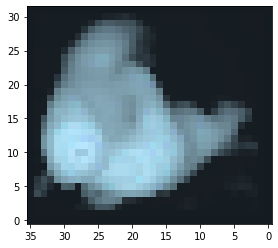

In [4]:
projection = shdom.OrthographicProjection(
    bounding_box=droplets.grid.bounding_box, 
    x_resolution=0.02, 
    y_resolution=0.02, 
    azimuth=0.0, 
    zenith=0.0,
    altitude='TOA'
)
camera = shdom.Camera(shdom.RadianceSensor(), projection)
image = camera.render(rte_solvers)

%matplotlib inline
plt.imshow(image/image.max())
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis() 